In [1]:
from base_rl.train import ParallelTrainer, OnlineTrainer
from base_rl.callbacks import SaveBestPolicy, SavePolicyOnTrainingEnd
import matplotlib.pyplot as plt
from q_learning.algorithm import QLearningAlgo, QLPolicy
from envs.env_creator import env_creator
from base_rl.eval_policy import EvalDiscreteStatePolicy
from base_rl.scheduler import DecayingExpScheduler, LinearScheduler, DecayingExpContinuousScheduler
import random

In [2]:
plt.rcParams["figure.figsize"] = [20, 12]
fixed_digits = 6
experiment_id = random.randrange(111111, 999999, fixed_digits)


## Init Model and env

In [3]:
device = 'cuda'
steps_per_episode = 1000
model_names = ['model_h_c', 'model_final_h', 'model_aeq']



alpha


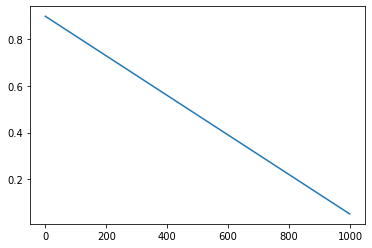

epsilon


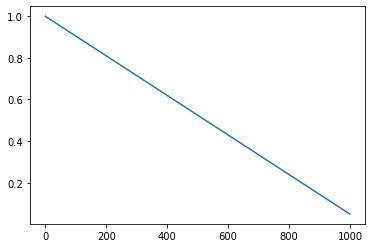

In [4]:


# alpha = np.logspace(np.log(0.9), np.log(0.05), 4500, base=np.exp(1))
# gamma = 0.995
# total_epochs = 6000
# epsilon = np.logspace(np.log(1), np.log(0.1), 4500, base=np.exp(1))

#alpha = np.logspace(np.log(0.9), np.log(0.05), 1000, base=np.exp(1))
#alpha = np.concatenate((alpha,np.ones(500)*0.05, alpha))


gamma = 0.99
total_epochs = 8000
print('alpha')
#alpha = LinearScheduler(start=0.9, end=0.05, total_steps=1000)
alpha = DecayingExpContinuousScheduler(start=0.9, decay=0.999)
print('epsilon')
epsilon = DecayingExpContinuousScheduler(start=0.8, decay=0.999)

In [5]:

best_save_paths = []
last_save_paths = []
models_env_kwargs = []
for model_name in model_names:
    policy_path = f'tmp/q_learning/q_policy_{model_name}_{experiment_id}.pkl'
    env_kwargs = {'steps_per_episode': steps_per_episode, 'device': device,
                  'model_path': f'tmp/state_quantization/{model_name}'}
    best_save_paths.append(f'tmp/q_learning/q_policy_best_{model_name}_{experiment_id}.pkl')
    last_save_paths.append(f'tmp/q_learning/q_policy_{model_name}_{experiment_id}.pkl')
    models_env_kwargs.append(env_kwargs)



In [6]:

workers_kwargs = []
for i, model_name in enumerate(model_names):
    trainer_config = {
        'algo': QLearningAlgo(
            comment=f',id={experiment_id},model={model_name},gamma={gamma},total_epochs={total_epochs}',
            epochs=total_epochs, alpha=alpha, gamma=gamma, epsilon=epsilon, env_creator=env_creator,
            env_kwargs=models_env_kwargs[i], reward_offset=2000, show_reward_type='mean'
        ),
        'callbacks': [
            SaveBestPolicy(save_path=best_save_paths[i]),
            SavePolicyOnTrainingEnd(save_path=last_save_paths[i])
        ]
    }
    workers_kwargs.append(trainer_config)

parallel_trainer = ParallelTrainer(trainer_class=OnlineTrainer, workers_kwargs=workers_kwargs)
parallel_trainer.train()

/home/hamza/PycharmProjects/StateCompression/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


<class 'state_quantization.quantization_models.ForcastingDiscFinalState'>
<class 'state_quantization.forcasting_quantization_models.ForcastingQuant'>


/home/hamza/PycharmProjects/StateCompression/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


<class 'state_quantization.quantization_models.ForcastingDiscHC'>


/home/hamza/PycharmProjects/StateCompression/venv/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


## Evaluate best saves

Episode 24 Reward: -186.40113592957266 || New State Found: False


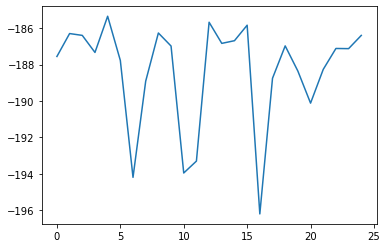

Reward Mean: -188.34736533041828
Reward std : 2.8810328767486046
tmp/state_quantization/model_h_c
Reward Mean: -187.85187166625713
Reward std : 0.8413643789734214
tmp/state_quantization/model_final_h
Reward Mean: -253.98835156759185
Reward std : 27.326423952598176
tmp/state_quantization/model_aeq
Reward Mean: -188.34736533041828
Reward std : 2.8810328767486046


In [7]:
evaluators = []
for i, model_name in enumerate(model_names):
    eval_policy = QLPolicy.load(best_save_paths[i])
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=models_env_kwargs[i])
    evaluator.evaluate(epochs=25)
    evaluators.append(evaluator)
for evaluator in evaluators:
    print(evaluator.env_kwargs['model_path'])
    print(f'Reward Mean: {evaluator.eval_mean}')
    print(f'Reward std : {evaluator.eval_std}')

## Evaluate last saves

Episode 12 Reward: -241.71138677681478 || New State Found: True


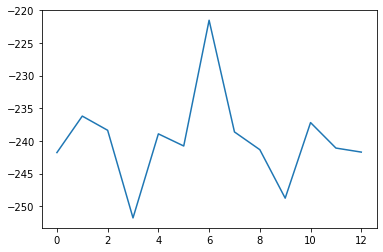

In [ ]:
evaluators = []
for i, model_name in enumerate(model_names):
    eval_policy = QLPolicy.load(last_save_paths[i])
    evaluator = EvalDiscreteStatePolicy(policy=eval_policy, env_creator=env_creator, env_kwargs=models_env_kwargs[i])
    evaluator.evaluate(epochs=25)
    evaluators.append(evaluator)
for evaluator in evaluators:
    print(evaluator.env_kwargs['model_path'])
    print(f'Reward Mean: {evaluator.eval_mean}')
    print(f'Reward std : {evaluator.eval_std}')